# Part 2, Model 2A: Glaucoma Detection using K-Nearest Neighbors (KNN), XgBoost and a linear C-Support Vector Classification (SVM classifier) on the fundus images of the eye + selected patient details + calculated OC + calculated OD. The features were extracted using the MobileNetV3 model.

In [1]:
%pip install scikit-learn
%pip install seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler  # Fix import statement
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

2024-02-10 17:59:56.683624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 17:59:56.683760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 17:59:56.775678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 17:59:56.949608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 17:59:58.290726: W tensorflow/compiler/tf2

In [3]:
tf.__version__

'2.15.0'

In [4]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('metadata - standardized.csv')

In [5]:
data.columns

Index(['names', 'types', 'type_expanded', 'isColor', 'original_name',
       'patient_id', 'fundus', 'fundus_od_seg', 'fundus_oc_seg', 'bv_seg',
       'artery_seg', 'vein_seg', 'oct', 'oct_oc_seg', 'oct_od_seg', 'sex',
       'gender', 'age', 'eye', 'sbp', 'dbp', 'hr', 'iop', 'vcdr',
       'Unnamed: 24', 'notchI_present', 'notchS_present', 'notchN_present',
       'notchT_present', 'expert1_grade', 'expert2_grade', 'expert3_grade',
       'expert4_grade', 'expert5_grade', 'cdr_avg', 'cdr_expert1',
       'cdr_expert2', 'cdr_expert3', 'cdr_expert4', 'refractive_dioptre_1',
       'refractive_dioptre_2', 'refractive_astigmatism',
       'phakic_or_pseudophakic', 'iop_perkins', 'iop_pneumatic', 'pachymetry',
       'axial_length', 'visual_field_mean_defect'],
      dtype='object')

In [6]:
data.head()

,names,types,type_expanded,isColor,original_name,patient_id,fundus,fundus_od_seg,fundus_oc_seg,bv_seg,...,cdr_expert4,refractive_dioptre_1,refractive_dioptre_2,refractive_astigmatism,phakic_or_pseudophakic,iop_perkins,iop_pneumatic,pachymetry,axial_length,visual_field_mean_defect
0,OIA-ODIR-TEST-OFFLINE-1,0,NaN,1,1029_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OIA-ODIR-TEST-OFFLINE-2,0,NaN,1,1049_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OIA-ODIR-TEST-OFFLINE-4,0,NaN,1,1128_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OIA-ODIR-TEST-OFFLINE-5,0,NaN,1,1179_right.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OIA-ODIR-TEST-OFFLINE-6,0,NaN,1,1180_left.jpg,NaN,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# know column type
data['fundus_oc_seg'].dtype

dtype('O')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   names                     12449 non-null  object 
 1   types                     12449 non-null  int64  
 2   type_expanded             6577 non-null   object 
 3   isColor                   12449 non-null  int64  
 4   original_name             12449 non-null  object 
 5   patient_id                488 non-null    object 
 6   fundus                    12449 non-null  object 
 7   fundus_od_seg             3103 non-null   object 
 8   fundus_oc_seg             3103 non-null   object 
 9   bv_seg                    462 non-null    object 
 10  artery_seg                22 non-null     object 
 11  vein_seg                  22 non-null     object 
 12  oct                       79 non-null     object 
 13  oct_oc_seg                45 non-null     object 
 14  oct_od

In [12]:
print(data['fundus'][12044])
print(data['fundus_oc_seg'][12044])
print(data['fundus_od_seg'][12044])

/full-fundus/PAPILA-484.png
/optic-cup/PAPILA-484.png
/optic-disc/PAPILA-484.png


full-fundus/full-fundus/PAPILA-484.png


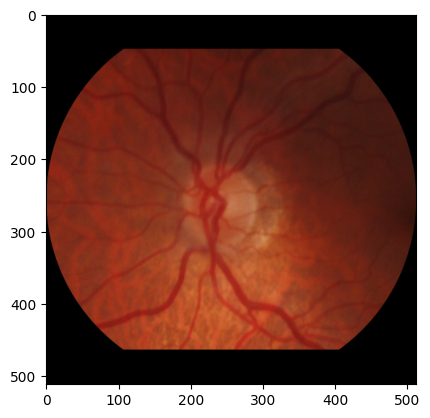

optic-cup/optic-cup/PAPILA-484.png


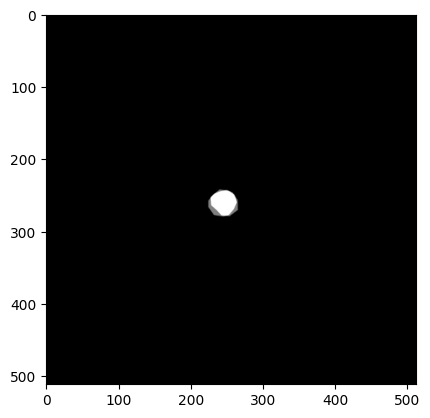

optic-disc/optic-disc/PAPILA-484.png


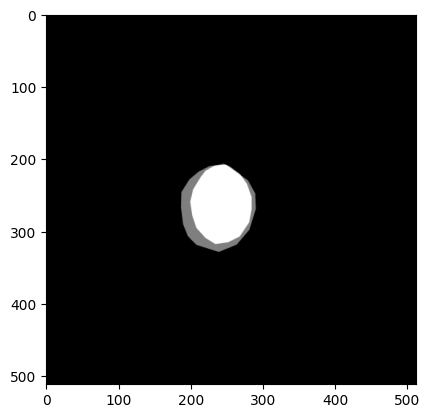

In [13]:
def viewFundus(image_path):

    image_path = 'full-fundus' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticCup(image_path):

    image_path = 'optic-cup' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()

def viewOpticDisc(image_path):

    image_path = 'optic-disc' + image_path

    print(image_path)

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('on')  # Hide the axis to only show the image
    plt.show()


viewFundus(data['fundus'][12044])
viewOpticCup(data['fundus_oc_seg'][12044])
viewOpticDisc(data['fundus_od_seg'][12044])

In [14]:
data["types"].value_counts()

types
 0    7549
 1    4767
-1     133
Name: count, dtype: int64

In [15]:
data["types"].value_counts().sum()

12449

In [16]:
#removing the patients with no fundus classification and with fundus classification -1 instead of 0,1
data = data[
    
    (data['fundus'].notnull()) & (data['types'] != -1)
    
]

fundus_subset = data[['types', 'fundus', 'names']]

fundus_subset['combined'] = fundus_subset['names'] + '.png'

fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)

fundus_subset['types'] = fundus_subset['types'].astype(str)

fundus_subset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12316 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   types     12316 non-null  object
 1   fundus    12316 non-null  object
 2   names     12316 non-null  object
 3   combined  12316 non-null  object
dtypes: object(4)
memory usage: 481.1+ KB


/tmp/ipykernel_1597/3636307318.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['combined'] = fundus_subset['names'] + '.png'
/tmp/ipykernel_1597/3636307318.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
/tmp/ipykernel_1597/3636307318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [17]:
fundus_subset['types'].value_counts()

types
0    7549
1    4767
Name: count, dtype: int64

In [18]:
fundus_subset

,types,fundus,names,combined
0,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-1.png,OIA-ODIR-TEST-OFFLINE-1,OIA-ODIR-TEST-OFFLINE-1.png
1,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-2.png,OIA-ODIR-TEST-OFFLINE-2,OIA-ODIR-TEST-OFFLINE-2.png
2,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-4.png,OIA-ODIR-TEST-OFFLINE-4,OIA-ODIR-TEST-OFFLINE-4.png
3,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-5.png,OIA-ODIR-TEST-OFFLINE-5,OIA-ODIR-TEST-OFFLINE-5.png
4,0,/full-fundus/OIA-ODIR-TEST-OFFLINE-6.png,OIA-ODIR-TEST-OFFLINE-6,OIA-ODIR-TEST-OFFLINE-6.png
...,...,...,...,...
12444,0,/full-fundus/FIVES-396.png,FIVES-396,FIVES-396.png
12445,0,/full-fundus/FIVES-397.png,FIVES-397,FIVES-397.png
12446,0,/full-fundus/FIVES-398.png,FIVES-398,FIVES-398.png
12447,0,/full-fundus/FIVES-399.png,FIVES-399,FIVES-399.png


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming fundus_subset is your DataFrame and 'types' is the column with labels
# Also assuming you have 'fundus_subset_random' DataFrame created earlier

testSize = 200
valSize = 200

# Calculate the number of samples for each class
glaucomaCount = len(fundus_subset[fundus_subset['types'] == '1'])
healthyCount = len(fundus_subset[fundus_subset['types'] == '0'])

print("this is the glaucoma count", glaucomaCount)
print("this is the healthy eyes count", healthyCount)

print('Total fundus images to  be used: ', glaucomaCount + healthyCount)

# Set the random seed for reproducibility
random_state = 1

# Create StratifiedShuffleSplit instance for test set
stratified_split_test = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=random_state)

for train_index, test_index in stratified_split_test.split(fundus_subset, fundus_subset['types']):
    train_set = fundus_subset.iloc[train_index]
    test = fundus_subset.iloc[test_index]

# Create StratifiedShuffleSplit instance for validation set
stratified_split_val = StratifiedShuffleSplit(n_splits=1, test_size=valSize, random_state=random_state)

for train_index, val_index in stratified_split_val.split(train_set, train_set['types']):
    train = train_set.iloc[train_index]
    val = train_set.iloc[val_index]

# Now train_set_final, val_set, and test_set contain the stratified splits

# Print the counts for each set
print("\nTrain set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

# You can access the features and labels as needed:
train_features = train.drop('types', axis=1)  # assuming 'types' is the label column
train_labels = train['types']
val_features = val.drop('types', axis=1)
val_labels = val['types']
test_features = test.drop('types', axis=1)
test_labels = test['types']

this is the glaucoma count 4767
this is the healthy eyes count 7549
Total fundus images to  be used:  12316

Train set size: 11916
Validation set size: 200
Test set size: 200


In [20]:
print("Train Size: ", len(train))
print("Test Size: ", len(test))

Train Size:  11916
Test Size:  200


In [22]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.experimental.preprocessing import Rescaling
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 


# Set target size and batch size for data generator
target = 512
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

with tf.device('/GPU:0'):


    # Create the training data generator
    trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    # Create the validation data generator
    valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


    # Create the testing data generator
    testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                            directory='full-fundus/full-fundus',   
                                            batch_size = batchSize, 
                                            class_mode = classes,
                                            shuffle=False, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 11916 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [25]:
# randomize data
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# create df for each class based on randomized data
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

with tf.device('/GPU:0'):

    # Set class mode to 'sparse' for visualization data generators
    classes = 'sparse'

    # Create data generators for healthy and glaucoma subsets for visualization
    healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')


    glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
    glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                                directory='full-fundus/full-fundus', 
                                                class_mode = classes,
                                                batch_size = batchSize, 
                                                shuffle=True, 
                                                x_col="combined", 
                                                y_col="types", 
                                                validate_filenames=True, 
                                                target_size=(target, target), 
                                                color_mode='rgb')

Found 7549 validated image filenames belonging to 1 classes.
Found 4767 validated image filenames belonging to 1 classes.


In [26]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(4, 4, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

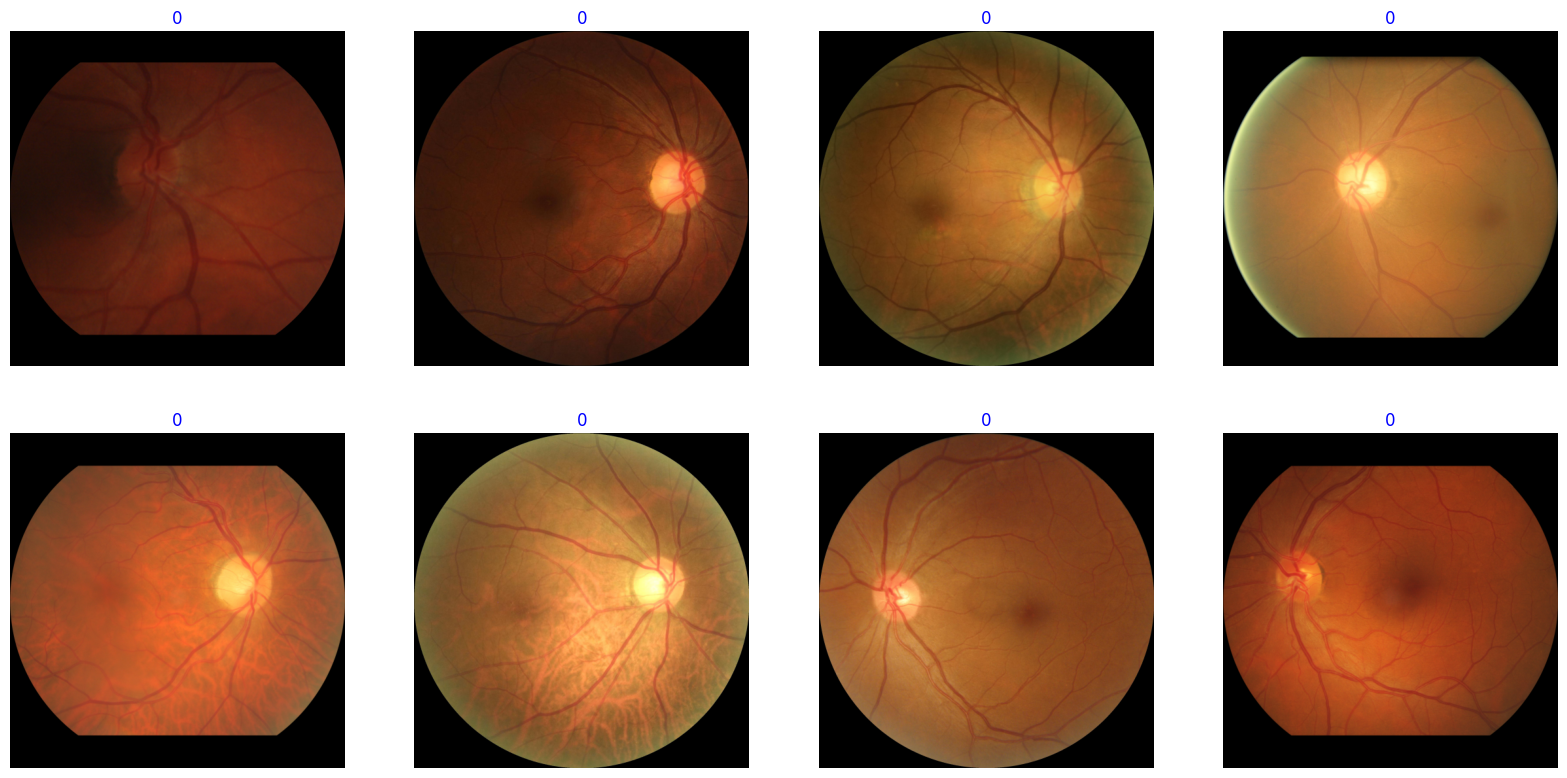

In [27]:
show_images(healthy_subset_Gen)

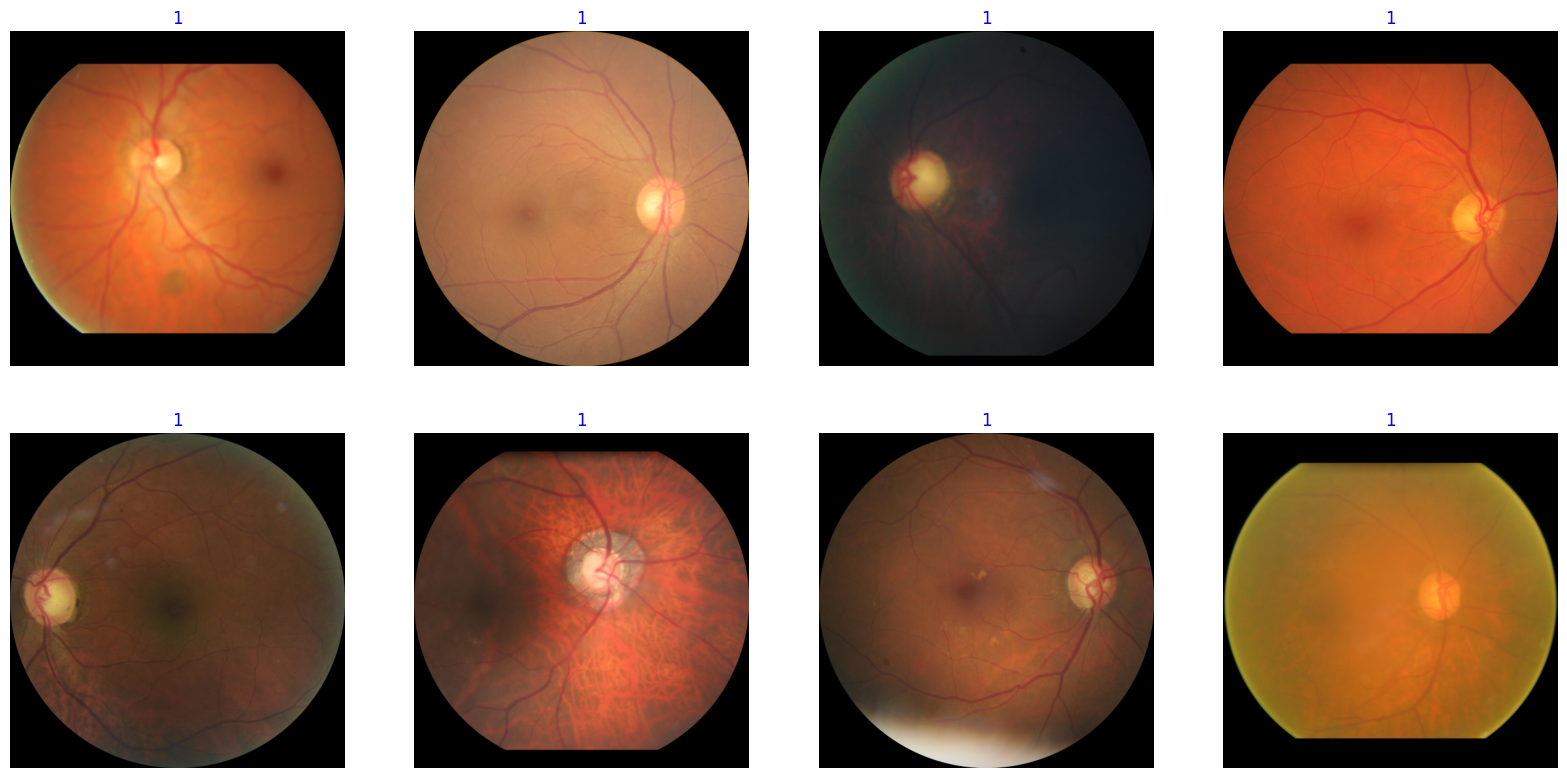

In [28]:
show_images(glaucoma_subset_Gen)

In [29]:
from keras.applications import MobileNetV3Small
from keras import Sequential

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(target, target, 3))

model = Sequential([
    base_model, layers.GlobalAveragePooling2D()
])

# Function to extract features using this model
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batchSize: (i + 1) * batchSize] = features_batch
        labels[i * batchSize: (i + 1) * batchSize] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

In [ ]:
from keras.applications import InceptionV3
from keras import Sequential
from keras.layers import GlobalAveragePooling2D
import numpy as np

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(target, target, 3))

# Assemble the sequential model with GlobalAveragePooling
model = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

# Function to extract features using the InceptionV3 model
def extract_features(generator, sample_count, batchSize):
    # Initialize a zeros array for features and labels
    features = np.zeros(shape=(sample_count, model.layers[-1].output.shape[1]))
    labels = np.zeros(shape=(sample_count))
    i = 0
    # Loop over the data generator
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        batch_size = inputs_batch.shape[0]
        features[i * batchSize: i * batchSize + batch_size] = features_batch
        labels[i * batchSize: i * batchSize + batch_size] = labels_batch
        i += 1
        if i * batchSize >= sample_count:
            break
    return features, labels

# Note: Make sure 'target' and 'batchSize' are defined before calling this function.
# 'target' should be the desired image size (e.g., 512 for a 512x512 input).
# 'batchSize' should match the batch size used in the generator.

In [30]:
import numpy as np

train_features, train_labels = extract_features(trainGen, trainGen.samples)
val_features, val_labels = extract_features(valGen, valGen.samples)
test_features, test_labels = extract_features(testGen, testGen.samples)

2024-02-10 18:11:42.334320: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-10 18:11:43.124419: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


2024-02-10 18:11:44.110550: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 99ms/step


2024-02-10 18:17:28.162599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165824 bytes after encountering the first element of size 25165824 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 [==============================] - 0s 73ms/step


In [31]:
from sklearn.svm import SVC

with tf.device('/GPU:0'):

    # Create and train the SVM
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(train_features, train_labels)

In [32]:
# Validate the SVM
val_accuracy = svm_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the SVM
test_accuracy = svm_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.86
Test accuracy: 0.86


In [33]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = svm_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[110  13]
 [ 15  62]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       123
         1.0       0.83      0.81      0.82        77

    accuracy                           0.86       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.86      0.86      0.86       200



In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=8, 
                                 weights='distance', 
                                 algorithm='auto', 
                                 leaf_size=30, 
                                 p=2, 
                                 metric='minkowski', 
                                 n_jobs=-1)
knn_model.fit(train_features, train_labels)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, weights='distance')

In [35]:
# Validate the KNN
val_accuracy = knn_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the KNN
test_accuracy = knn_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.85
Test accuracy: 0.845


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = knn_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[117   6]
 [ 25  52]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.95      0.88       123
         1.0       0.90      0.68      0.77        77

    accuracy                           0.84       200
   macro avg       0.86      0.81      0.83       200
weighted avg       0.85      0.84      0.84       200



In [37]:
import xgboost as xgb

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [38]:
# Validate the xgb model
val_accuracy = xgb_model.score(val_features, val_labels)
print('Validation accuracy:', val_accuracy)

# Test the xgb model
test_accuracy = xgb_model.score(test_features, test_labels)
print('Test accuracy:', test_accuracy)

Validation accuracy: 0.835
Test accuracy: 0.85


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

test_predictions = xgb_model.predict(test_features)

conf_matrix = confusion_matrix(test_labels, test_predictions)
class_report = classification_report(test_labels, test_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[112  11]
 [ 19  58]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       123
         1.0       0.84      0.75      0.79        77

    accuracy                           0.85       200
   macro avg       0.85      0.83      0.84       200
weighted avg       0.85      0.85      0.85       200



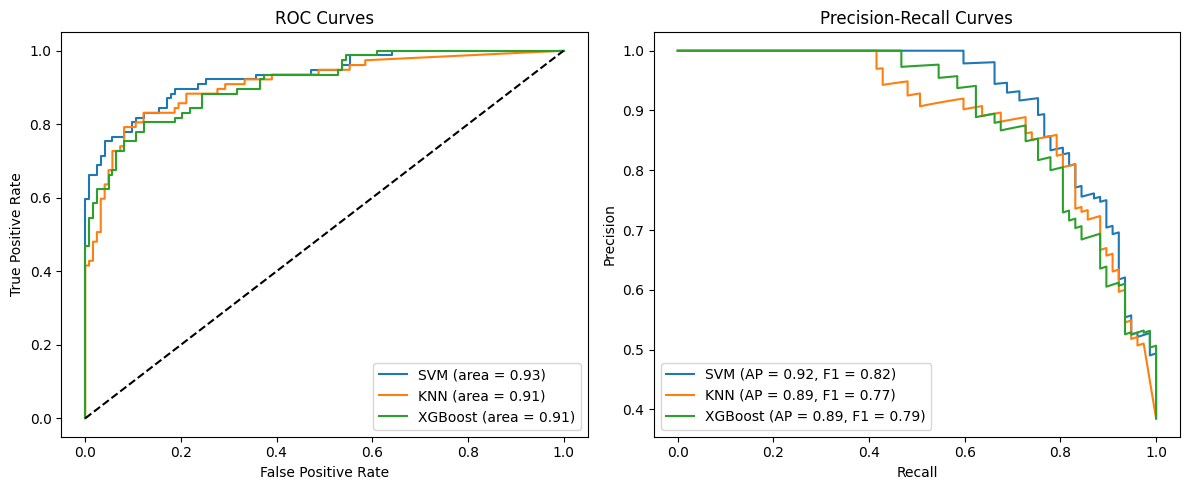

In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt

# Assuming you have the true labels and predicted probabilities for each model
true_labels = test_labels
svm_probs = svm_model.predict_proba(test_features)[:, 1]

# KNN probabilities
knn_probs = knn_model.predict_proba(test_features)[:, 1]

# XGBoost probabilities
xgb_probs = xgb_model.predict_proba(test_features)[:, 1]

# Calculate ROC curve and ROC area for each model
fpr_svm, tpr_svm, _ = roc_curve(true_labels, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(true_labels, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_xgb, tpr_xgb, _ = roc_curve(true_labels, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Calculate Precision-Recall curve and F1 score for each model
precision_svm, recall_svm, _ = precision_recall_curve(true_labels, svm_probs)
ap_svm = average_precision_score(true_labels, svm_probs)
f1_svm = f1_score(true_labels, svm_probs.round())

precision_knn, recall_knn, _ = precision_recall_curve(true_labels, knn_probs)
ap_knn = average_precision_score(true_labels, knn_probs)
f1_knn = f1_score(true_labels, knn_probs.round())

precision_xgb, recall_xgb, _ = precision_recall_curve(true_labels, xgb_probs)
ap_xgb = average_precision_score(true_labels, xgb_probs)
f1_xgb = f1_score(true_labels, xgb_probs.round())

# Plot all ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (area = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')

# Plot all Precision-Recall curves
plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f}, F1 = {f1_svm:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {ap_knn:.2f}, F1 = {f1_knn:.2f})')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f}, F1 = {f1_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

In [172]:
# # Plot the confusion matrix heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.title('Confusion Matrix Heatmap')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.show()

In [173]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# # define sequential model
# svm_model = Sequential()
# # define conv-pool layers - set 1
# svm_model.add(Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid', input_shape = (224, 224, 3)))
# svm_model.add(BatchNormalization(axis=3))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # define conv-pool layers - set 2
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))

# svm_model.add(MaxPooling2D(pool_size=(2, 2)))

# # define conv-pool layers - set 3
# svm_model.add(Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1),
# activation='relu', padding='valid'))
# svm_model.add(MaxPooling2D(pool_size=(2, 2)))


# # add flatten layer
# svm_model.add(Flatten())

# # add dense layers with some dropout
# svm_model.add(Dense(512, activation='relu'))
# svm_model.add(Dropout(rate = 0.2))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(256, activation='relu'))
# svm_model.add(Dense(128, activation='relu'))

# # add output layer
# svm_model.add(Dense(1, kernel_regularizer = l2(0.01), activation='linear'))

# svm_model.summary()

In [174]:
# from keras.callbacks import TensorBoard, EarlyStopping
# from datetime import datetime

# logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [175]:
# from keras.backend import epsilon

# def f1_score_metric(y_true, y_pred):
#     y_pred = tf.round(y_pred)
#     return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + epsilon())

In [176]:
# with tf.device('/GPU:0'):

#     svm_model.compile(optimizer = 'adam',
#                 loss = 'squared_hinge',
#                 metrics=['accuracy','Precision','Recall','AUC',f1_score_metric])

#     r=svm_model.fit(trainGen,
#                 batch_size = 32,
#                 verbose = 1,
#                 epochs = 10,
#                 validation_data = valGen,
#                 callbacks = [tensorboard_callback, es],)

In [177]:
# # Evaluate the model on the validation data
# score=svm_model.evaluate(valGen)
# score

In [178]:
# # Plot the training and validation accuracy and loss
# import seaborn as sns
# sns.set()

# acc = r.history['accuracy']
# val_acc = r.history['val_accuracy']
# loss = r.history['loss']
# val_loss = r.history['val_loss']
# epochs = range(1, len(loss) + 1)

# #accuracy plot
# plt.plot(epochs, acc, color='green', label='Training Accuracy')
# plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# plt.figure()
# #loss plot
# plt.plot(epochs, loss, color='green', label='Training Loss')
# plt.plot(epochs, val_loss, color='red', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [179]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Generate predictions
# predictions = svm_model.predict(testGen)
# predictions = np.round(predictions).astype(int).flatten()  # Adjust based on your output format

# # Get true labels
# true_labels = testGen.labels

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy}")

# # Generate and print confusion matrix
# conf_matrix = confusion_matrix(true_labels, predictions)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Generate and print classification report
# class_report = classification_report(true_labels, predictions)
# print("Classification Report:")
# print(class_report)